In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

# Standard
import os
import shutil
import glob
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np

# # Third Party
import rioxarray as rio
from lightning.pytorch import Trainer
from terratorch.cli_tools import LightningInferenceModel
from huggingface_hub import hf_hub_download

# First Party
from utils.binwise_rmse import calc_binwise_rmse
from utils.dataset_scalers import calc_mean_std
from utils.plotting import plot_rgb_agb_gedi

# ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-biomass", filename="biomass_model.ckpt")
# print(ckpt_path)

NumPy version: 1.26.4
Pandas version: 1.5.3


In [2]:
### Provide all necessary files, paths, and hyperparameter

# Path to configuration file which contains all hyperparameters
config_path = './configs/config.yaml'

# Path to directory with geotiff test images
predict_input_dir = '../granite-geospatial-biomass-datasets/all_ecos_datasplit/test_images/'

# List to define the bands in the input images. As currently configured, the model looks for following
# HLS bands: BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2
# The line below names all the bands in the input, so the ones above can be extracted. we use -1 for placeholders, as we dont care about those
UNUSED_BAND = "-1"
predict_dataset_bands = [UNUSED_BAND,"BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2",UNUSED_BAND,UNUSED_BAND,UNUSED_BAND,UNUSED_BAND]

# Path to directory with GEDI test labels - these will be used for plotting and evaluation further below
test_label_dir = '../granite-geospatial-biomass-datasets/all_ecos_datasplit/test_labels/'

# create subset of images for inference
images_for_inference = ['T10SFF_144_tile_img.tif', 'T33TUM_34_tile_img.tif', 'T47PRR_79_tile_img.tif']

labels_for_inference = ['T10SFF_144_tile_label.tif', 'T33TUM_34_tile_label.tif', 'T47PRR_79_tile_label.tif']

if not os.path.isdir("inference_images"):
    os.mkdir("inference_images")
    for inference_image in images_for_inference:
        shutil.copy(os.path.join(predict_input_dir, inference_image), os.path.join("inference_images", inference_image))

if not os.path.isdir("inference_labels"):
    os.mkdir("inference_labels")
    for inference_label in labels_for_inference:
        shutil.copy(os.path.join(test_label_dir, inference_label), os.path.join("inference_labels", inference_label))

In [2]:
# load the model with terratorch
config_path = './configs/config.yaml'
ckpt_path = './biomass_model.ckpt'
UNUSED_BAND = "-1"
predict_dataset_bands = [UNUSED_BAND,"BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2",UNUSED_BAND,UNUSED_BAND,UNUSED_BAND,UNUSED_BAND]
model = LightningInferenceModel.from_config(config_path, ckpt_path, predict_dataset_bands)

/home/glyin/anaconda3/envs/granite_env/lib/python3.11/site-packages/lightning/pytorch/cli.py:520: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/home/glyin/.local/share/jupyter/runtime/kernel-v31a9e653b4a2f794a6b61bc420a65626a95955dd3.json'], args=['--config', './configs/config.yaml', '--data.init_args.predict_dataset_bands', '[-1,BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,-1,-1,-1,-1]'].
Seed set to 42
No pretrained configuration specified for prithvi_swin_B model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


/home/glyin/anaconda3/envs/granite_env/lib/python3.11/site-packages/lightning/pytorch/cli.py:654: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glyin/anaconda3/envs/granite_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
model.model

PixelwiseRegressionTask(
  (model): PixelWiseModel(
    (encoder): FeatureListNet(
      (patch_embed): PatchEmbed(
        (drop): Dropout(p=0.0, inplace=False)
        (adap_padding): AdaptivePadding()
        (projection): Conv2d(6, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (stages_0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath(drop_prob=0.000)
            )
            (nor

In [5]:
# read tiff
data_ = rio.open_rasterio('inference_images/T10SFF_144_tile_img.tif').to_numpy()

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class if needed
class CustomDataset(Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random image data with shape (10, 224, 224)
        img_data = np.random.rand(6, 224, 224).astype(np.float32)  # 10 bands
        # Generate random label data with shape (1, 224, 224)
        label_data = np.random.rand(1, 224, 224).astype(np.float32)  # 1 label

        # Convert to PyTorch tensors
        img_tensor = torch.tensor(img_data)
        label_tensor = torch.tensor(label_data)

        return img_tensor, label_tensor

# Create DataLoader for your dataset
train_dataset = CustomDataset()
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Define optimizer and loss function
optimizer = optim.Adam(model.model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()  # or any other loss function suitable for your task

fine_tuned_model = model.model.to(device)

batch_size = 16  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

scaler = GradScaler()  # For mixed precision

for epoch in range(10):
    fine_tuned_model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Enable mixed precision
            outputs = fine_tuned_model(images)
            output_tensor = outputs.output
            if output_tensor.dim() == 3:
                output_tensor = output_tensor.unsqueeze(1)

            loss = criterion(output_tensor, labels)

        scaler.scale(loss).backward()  # Scale the loss
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scale for next iteration

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.cuda.empty_cache() 

# Save the fine-tuned model if needed
torch.save(model.model.state_dict(), 'fine_tuned_model.pth')

In [7]:
import torch
torch.cuda.empty_cache() 



In [ ]:
inference_results_masked, input_file_names_masked = model.inference_on_dir("masked_images")
inference_results, input_file_names = model.inference_on_dir("inference_images")

AGB GEDI (ground truth): 142.32687
AGB Predicted: 84.82204
Mean Squared Error (excluding NaN points): 20871.806640625
Root Mean Squared Error (excluding NaN points): 144.4707794189453
R-squared (excluding NaN points): -0.0383681058883667
AGB GEDI (ground truth): 149.3419
AGB Predicted: 69.044235
Mean Squared Error (excluding NaN points): 24873.96484375
Root Mean Squared Error (excluding NaN points): 157.71482849121094
R-squared (excluding NaN points): -0.15570151805877686


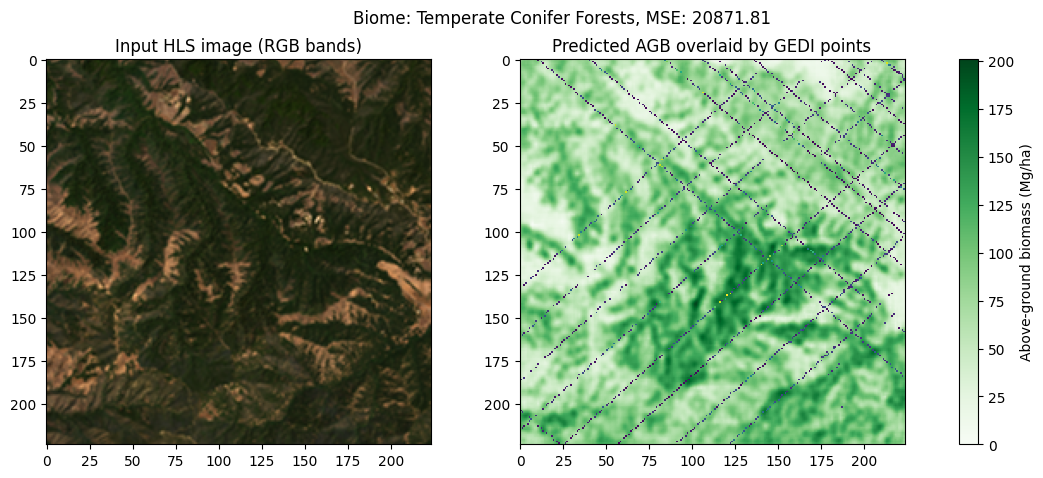

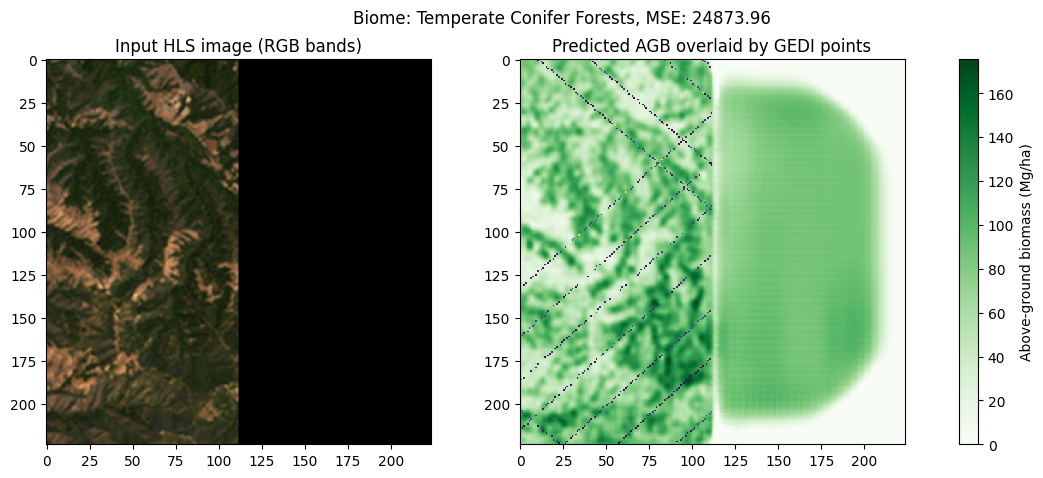

In [5]:
### Plot example image for Temperate Conifer Forests
biome = 'Temperate Conifer Forests'
tile_id = 'T10SFF_144' # Located in CA, USA

plot_rgb_agb_gedi(tile_id, "inference_images", input_file_names, inference_results, "inference_labels", biome)
plot_rgb_agb_gedi(tile_id, "masked_images", input_file_names_masked, inference_results_masked, "masked_labels", biome)